# <center> <ins> Amazon Reviews

- Google Colab - https://colab.research.google.com/drive/1pfooETyM4ZQ8d6tdPM7nHG1Pm0lb5x1W?usp=sharing
- Github Link (For models and training scripts) - https://github.com/xzodia1000/text-analysis

## Importing necessary libraries

In [1]:
import re
import string
import contractions
import gensim
import warnings
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from scipy.stats import expon, reciprocal
from scipy.sparse import save_npz, load_npz

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.exceptions import ConvergenceWarning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Embedding,
    LSTM,
    SpatialDropout1D,
    BatchNormalization,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset


from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

# from spellchecker import SpellChecker

2024-04-02 00:10:52.878620: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 00:10:53.258221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 00:10:53.258273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 00:10:53.345946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 00:10:53.495092: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# pandas with tqdm
tqdm.pandas()

nltk.download("wordnet")

nltk.download("stopwords")

nltk.download('punkt')

#! warnings.filterwarnings("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package wordnet to /home/xzodia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/xzodia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/xzodia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading the data 

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
print(f"shape of testing data: {test.shape}")

shape of testing data: (123622, 2)


In [4]:
train = train[['Review', 'overall']]
print(f"shape of training data: {train.shape}")
train.head()

shape of training data: (370863, 2)


,Review,overall
0,I love these glitter pens. They sparkle deligh...,5
1,It works well with my machine. I use mostly c...,5
2,"This is a great assortment of colors, though t...",5
3,Just what I was looking for.,5
4,I make 400 birds for the hospital each month.,5


---

## <ins>Exploratory Data Analysis

### 1) <ins> Missing Values

In [18]:
# check for missing values
print(f"missing values in Review column of training data: {train['Review'].isnull().sum()}")
print(f"missing values in overall column of training data: {train['overall'].isnull().sum()}")

missing values in Review column of training data: 8
missing values in overall column of training data: 0


#### We have 8 rows in the training dataset with empty reviews, we will remove them.

In [5]:
# remove the rows with missing reviews
train = train.dropna(subset=['Review'])
print(f"shape of training data after removing missing reviews: {train.shape}")

shape of training data after removing missing reviews: (370855, 2)


### 2) <ins> Distribution of Ratings

In [22]:
# Table for the number of reviews for each rating
rating_counts = train['overall'].value_counts().sort_index()
rating_counts = pd.DataFrame(rating_counts).reset_index()
rating_counts.columns = ['Rating', 'Number of Reviews']
rating_counts

,Rating,Number of Reviews
0,1,10772
1,2,9624
2,3,21470
3,4,45831
4,5,283158


- ### Bar plot of the distribution of ratings

c:\Users\dhruv\anaconda3\envs\TF\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dhruv\anaconda3\envs\TF\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dhruv\anaconda3\envs\TF\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


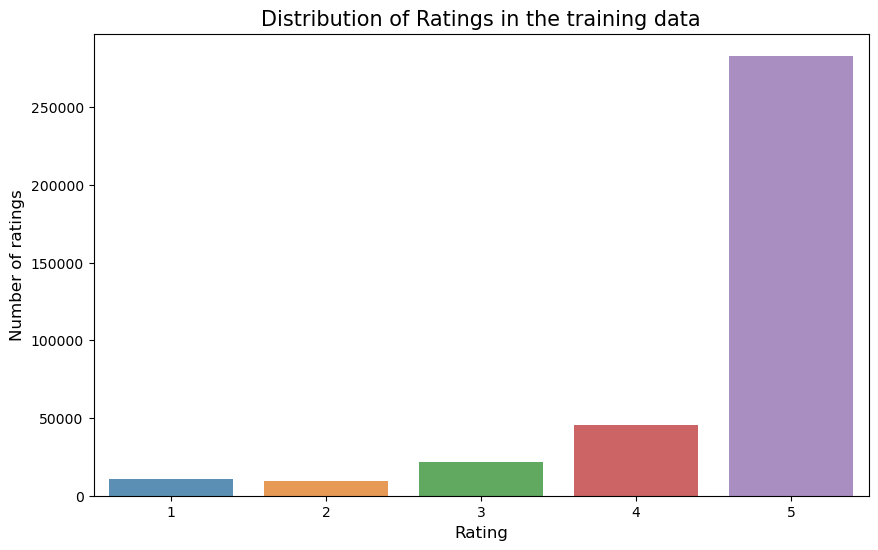

In [10]:
# plot the number of ratings for each rating
number = train['overall'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=number.index, y=number.values, alpha=0.8)
plt.title('Distribution of Ratings in the training data', fontsize=15)  
plt.ylabel('Number of ratings', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.show()

- ### Pie chart of the percentage distribution of ratings

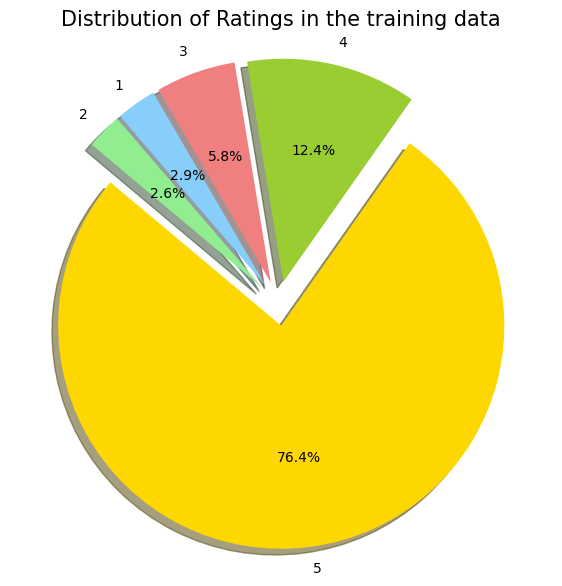

In [11]:
# pie chart
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
explode = (0.1, 0.1, 0.1, 0.1, 0.1)

plt.figure(figsize=(7, 7))
plt.pie(number.values, explode=explode, labels=number.index, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Ratings in the training data', fontsize=15)
plt.axis('equal')
plt.show()

#### Based on the above plot, we can see that the data is heavily imbalanced. The 5 star reviews comprise of 76.4% of the entire training data. To deal with this, we will use a <ins>weighted loss function proportional to the class imbalance</ins>, so that the model can learn from the minority classes as well.

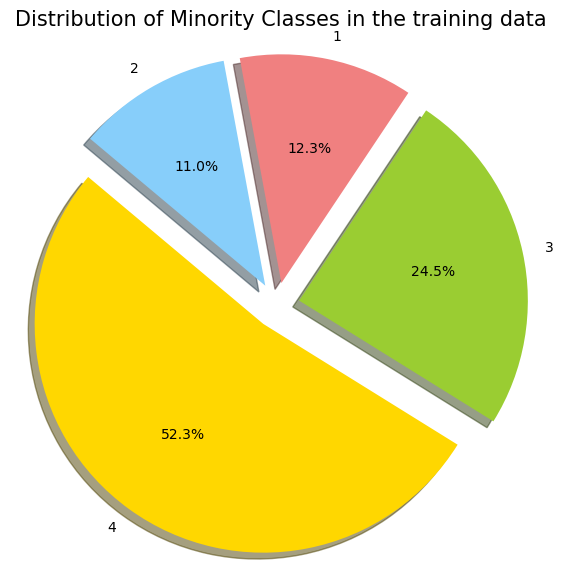

In [15]:
# Pie chart for rating distribution Without 5 star rating
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0.1, 0.1, 0.1)

plt.figure(figsize=(7, 7))
plt.pie(number.values[1:], explode=explode, labels=number.index[1:], colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Minority Classes in the training data', fontsize=15)
plt.axis('equal')
plt.show()

### 3) <ins> Checking if data is shuffled

In [52]:
# number of unique ratings in first 10,000 reviews
train['overall'][:10000].value_counts()

overall
5    7691
4    1208
3     570
1     270
2     261
Name: count, dtype: int64

#### As we have different labels in the first 10,000 rows, we can conclude that the data is shuffled.

---

## <ins>Text Processing and Normalization

### 1) <ins> Text Processing Class

In [6]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.punctuations = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        # self.spell = SpellChecker()

    def lowercase(self, text):
        return text.lower()
    
    def remove_punctuation(self, text):
        return text.translate(self.punctuations)
    
    def tokenize(self, text):
        return word_tokenize(text)

    def remove_stop_words(self, tokens):
        stop_words = set(stopwords.words("english"))
        return [word for word in tokens if word not in stop_words]
    
    def remove_numbers(self, tokens):
        return [word for word in tokens if not word.isdigit()]
    
    def POS_tagging(self, tokens):
        return pos_tag(tokens)
    
    #Function to convert nltk pos tags to wordnet pos tags
    def get_wordnet_pos(self, treebank_tag):
        try:
            if treebank_tag.startswith("J"):
                return wordnet.ADJ
            elif treebank_tag.startswith("V"):
                return wordnet.VERB
            elif treebank_tag.startswith("N"):
                return wordnet.NOUN
            elif treebank_tag.startswith("R"):
                return wordnet.ADV
            elif treebank_tag.startswith("P"):
                return wordnet.NOUN
            else:
                return ""
        except:
            print(treebank_tag, f" is not a valid treebank tag")
            return ""
    
    def lemmatize(self, pos_tags):
        lemmatized_tokens = []
        for token, pos_tag in pos_tags:
            wordnet_pos = self.get_wordnet_pos(pos_tag)
            lemma = (
                self.lemmatizer.lemmatize(token, pos=wordnet_pos)
                if wordnet_pos
                else self.lemmatizer.lemmatize(token)
            )
            lemmatized_tokens.append(lemma)
        return lemmatized_tokens
    
    #! function to correct spelling mistakes in the text
    # def correct_spelling(self, text):
    #     words = text.split()
    #     corrected_words = [(self.spell.correction(word) if self.spell.correction(word) else word) for word in words]
    #     corrected_sentence = ' '.join(corrected_words)
    #     return corrected_sentence

    
    #* function to expand contractions like "I'm" to "I am"
    def expand_contractions(self, text):
        return contractions.fix(text)
    
    #* function to remove words starting with a backslash like "\n" using regex
    def rem_backslash_words(self, text):
        # Replace HTML line breaks with space
        text = re.sub(r'<br\s*/?>', ' ', text)
        # Replace tabs and newlines with a space
        text = re.sub(r'\s+', ' ', text)
        # Optionally, strip leading/trailing whitespace
        text = text.strip()
        return text


    def preprocess(self, text):
        lower_text = self.lowercase(text)
        expanded_text = self.expand_contractions(lower_text)
        no_punc_text = self.remove_punctuation(expanded_text)
        no_backslash = self.rem_backslash_words(no_punc_text)
        # spell_checked = self.correct_spelling(no_backslash)
        tokens = self.tokenize(no_backslash)
        no_stop = self.remove_stop_words(tokens)
        no_numbers = self.remove_numbers(no_stop)
        pos_tags = self.POS_tagging(no_numbers)
        lemmatized = self.lemmatize(pos_tags)
        return lemmatized
    

pre_processor = TextPreprocessor()

# text = "helo, my naem is john \n\n \n \r \t"
# cleaned = PreProcessor.rem_backslash_words(text)
# print(cleaned)

In [7]:
# carrying out the preprocessing, and storing the tokens in another dataframe with columns 'pre_processed tokens' and 'overall'
train["tokenized"] = train["Review"].progress_apply(lambda x: pre_processor.preprocess(x))

processed_train = train[["tokenized", "overall"]]
processed_train.loc[:, "tokenized_joined"] = processed_train["tokenized"].progress_apply(lambda x: " ".join(x))

processed_train.head()

100%|██████████| 370855/370855 [00:00<00:00, 1545480.89it/s]


,tokenized,overall,tokenized_joined
0,"[love, glitter, pen, sparkle, delightfully, pa...",5,love glitter pen sparkle delightfully page bri...
1,"[work, well, machine, use, mostly, cone]",5,work well machine use mostly cone
2,"[great, assortment, color, though, lot, pink, ...",5,great assortment color though lot pink mix sti...
3,[look],5,look
4,"[make, bird, hospital, month]",5,make bird hospital month


In [8]:
processed_train = processed_train[["tokenized", "tokenized_joined", "overall"]]
print(processed_train.shape)
processed_train.head()

(370855, 3)


,tokenized,tokenized_joined,overall
0,"[love, glitter, pen, sparkle, delightfully, pa...",love glitter pen sparkle delightfully page bri...,5
1,"[work, well, machine, use, mostly, cone]",work well machine use mostly cone,5
2,"[great, assortment, color, though, lot, pink, ...",great assortment color though lot pink mix sti...,5
3,[look],look,5
4,"[make, bird, hospital, month]",make bird hospital month,5


### 2) <ins>Discussion on the text processing and normalization techniques used

- lowercasing: lowercasing all the text in the reviews, so that the model does not treat the same word in different cases as different words.
- punctuation removal: removing all the punctuations from the reviews.
- removing stopwords: removing all the stopwords from the reviews, so that the model can focus on the important words.
- lemmatization: converting all the words to their base form, so that the model can treat the same word in different forms as the same word.
- POS tagging: tagging all the words with their parts of speech, so that the model can understand the context of the words.
- removing non-alphabetic characters: removing all the non-alphabetic characters from the reviews.
- expanding contractions: expanding all the contractions in the reviews, so that the model can understand the full form of the words, and does not treat them as different words.

---

## <ins>Feature Representation

In [93]:
def document_vector(model, doc):
    doc = [word for word in doc if word in model.wv]
    if not doc:
        return np.zeros(model.vector_size)

    return np.mean(model.wv[doc], axis=0)


# function for creating representations of the text
def create_representations(representation):
    vectorizer = None
    if representation == "one_hot":
        vectorizer = CountVectorizer(binary=True)
    elif representation == "frequency":
        vectorizer = CountVectorizer()
    elif representation == "tf_idf":
        vectorizer = TfidfVectorizer()
    elif representation == "OneGram":
        vectorizer = CountVectorizer(ngram_range=(1, 1))
    elif representation == "TwoGram":
        vectorizer = CountVectorizer(ngram_range=(2, 2))
    elif representation == "ThreeGram":
        vectorizer = CountVectorizer(ngram_range=(3, 3))
    elif representation == "cbow":
        model = gensim.models.Word2Vec(
            processed_train["tokenized"].to_list(),
            min_count=1,
            vector_size=100,
            window=5,
        )
    elif representation == "skipgram":
        model = gensim.models.Word2Vec(
            processed_train["tokenized"].to_list(),
            min_count=1,
            vector_size=100,
            window=5,
            sg=1,
        )
    else:
        raise ValueError("Invalid representation type")

    if vectorizer == None and model:
        X_representation = np.array(
            [document_vector(model, doc) for doc in processed_train["tokenized"]]
        )
        np.savez_compressed(
            f"./representations/X_{representation}.npz", features=X_representation
        )
    else:
        X_representation = vectorizer.fit_transform(processed_train["tokenized_joined"])
        save_npz(f"./representations/X_{representation}.npz", X_representation)

In [94]:
representations = [
    #"one_hot",
    #"frequency",
    "tf_idf",
    "OneGram",
    "TwoGram",
    #"ThreeGram",
    "cbow",
    "skipgram",
]

for representation in tqdm(representations):
    create_representations(representation)

100%|██████████| 8/8 [02:40<00:00, 20.03s/it]


We decided to create 5 different representation of the reviews:

1) <ins> Unigram:</ins> It is the simplest form of text representation, where each word in the review is treated as a separate feature.

2) <ins> Bigram:</ins> It is a more complex form of text representation, where each pair of adjacent words in the review is treated as a separate feature.

3) <ins> tf-idf:</ins> It is a more advanced form of text representation, where each word in the review is assigned a weight based on its frequency in the review and its frequency in the entire dataset.

4) <ins> cbow (Continuous Bag of Words):</ins> It is a neural network model that predicts the current word based on its context. It is a type of word2vec model.

5) <ins> skip-gram:</ins> It is a neural network model that predicts the context words based on the current word. It is a type of word2vec model.

--- 

## Modelling

### SVM

In [27]:
def train_model(model, hparams, representation):
    if representation == "cbow" or representation == "skipgram":
        X = np.load(f"./representations/X_{representation}.npz")["features"]
    else:
        X = load_npz(f"./representations/X_{representation}.npz")
    y = train["overall"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training {model} on {representation} representation")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=hparams,
        n_iter=10,
        cv=5,
        verbose=4,
        n_jobs=-1,
        random_state=42,
    )

    # Fit RandomizedSearchCV on the training set
    random_search.fit(X_train, y_train)

    print(f"Training {model} on {representation} representation completed")

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    y_pred = best_model.predict(X_test)
    accuracy = best_model.score(X_test, y_test)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return best_model, best_params, accuracy, class_report, conf_matrix

In [19]:
hparams_SVC = {
    'C': reciprocal(0.1, 100),  # Regularization parameter
    'gamma': expon(scale=1.0),  # Kernel coefficient
    'kernel': ['rbf'],  # Assuming we're only interested in the RBF kernel here
    'max_iter': [100],
}

In [32]:
representations = [
    "tf_idf",
    "OneGram",
    "TwoGram",
    "cbow",
    "skipgram",
]

svc_dict = {}

for representation in tqdm(representations):
    best_model, best_params, accuracy, class_report, conf_matrix = train_model(SVC(), hparams_SVC, representation)
    svc_dict.update({
        f"{representation}_model": best_model,
        f"{representation}_params": best_params,
        f"{representation}_accuracy": accuracy,
        f"{representation}_class_report": class_report,
        f"{representation}_conf_matrix": conf_matrix,
    })    

  0%|          | 0/5 [00:00<?, ?it/s]

Training SVC() on tf_idf representation
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training SVC() on tf_idf representation completed


 20%|██        | 1/5 [03:31<14:05, 211.32s/it]

Training SVC() on OneGram representation
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training SVC() on OneGram representation completed


 40%|████      | 2/5 [07:15<10:57, 219.13s/it]

Training SVC() on TwoGram representation
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training SVC() on TwoGram representation completed


c:\Users\dhruv\anaconda3\envs\text\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dhruv\anaconda3\envs\text\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dhruv\anaconda3\envs\text\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|█████

Training SVC() on cbow representation
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training SVC() on cbow representation completed


 80%|████████  | 4/5 [19:57<06:05, 365.89s/it]

Training SVC() on skipgram representation
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training SVC() on skipgram representation completed


100%|██████████| 5/5 [30:48<00:00, 369.72s/it]


---

In [ ]:
# storing results in a pickle file
with open("./models/svc_dict.pkl", "wb") as f:
    pickle.dump(svc_dict, f)

In [13]:
# read from pickle and store in a dictionary
with open("./models/svc_dict.pkl", "rb") as f:
    svc_dict = pickle.load(f)

/home/xzodia/anaconda3/envs/tf-text/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# print the class report for each representation
for key, value in svc_dict.items():
    if "class_report" in key:
        print(f"Class report for {key}:")
        print(value)

Class report for tf_idf_class_report:
              precision    recall  f1-score   support

           1       0.24      0.40      0.30      2104
           2       0.12      0.37      0.18      1987
           3       0.32      0.02      0.04      4229
           4       0.23      0.11      0.15      9251
           5       0.84      0.88      0.86     56600

    accuracy                           0.71     74171
   macro avg       0.35      0.36      0.31     74171
weighted avg       0.69      0.71      0.69     74171

Class report for OneGram_class_report:
              precision    recall  f1-score   support

           1       0.05      0.71      0.09      2104
           2       0.05      0.07      0.06      1987
           3       0.05      0.11      0.07      4229
           4       0.12      0.07      0.09      9251
           5       0.84      0.38      0.52     56600

    accuracy                           0.32     74171
   macro avg       0.22      0.27      0.16     74171


In [14]:
for key, value in svc_dict.items():
    if "params" in key:
        print(f"Best parameters for {key}:")
        print(value)

Best parameters for tf_idf_params:
{'C': 1.3292918943162166, 'gamma': 3.010121430917521, 'kernel': 'rbf', 'max_iter': 1000}
Best parameters for OneGram_params:
{'C': 0.2938027938703535, 'gamma': 0.16959629191460518, 'kernel': 'rbf', 'max_iter': 1000}
Best parameters for TwoGram_params:
{'C': 0.2938027938703535, 'gamma': 0.16959629191460518, 'kernel': 'rbf', 'max_iter': 1000}
Best parameters for cbow_params:
{'C': 0.115279871282324, 'gamma': 3.503557475158312, 'kernel': 'rbf', 'max_iter': 1000}
Best parameters for skipgram_params:
{'C': 0.2938027938703535, 'gamma': 0.16959629191460518, 'kernel': 'rbf', 'max_iter': 1000}


---

### Random Forest

In [25]:
hparams_RF = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=20)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(5, 120, num=12)] + [None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'max_samples': [0.5, 0.75, 0.25],  # Consider smaller fractions for large datasets
    'class_weight': ['balanced_subsample'],  # Important for imbalance
    'criterion': ['gini', 'entropy'],
}


In [ ]:
representations = [
    "tf_idf",
    "OneGram",
    "TwoGram",
    "cbow",
    "skipgram",
]

RF_dict = {}

for representation in tqdm(representations):
    best_model, best_params, y_pred, class_report, conf_matrix = train_model(RandomForestClassifier(), hparams_RF, representation)
    RF_dict.update({
        # f"{representation}_model": best_model,
        f"{representation}_params": best_params,
        f"{representation}_y_pred": y_pred,
        f"{representation}_class_report": class_report,
        f"{representation}_conf_matrix": conf_matrix,
    })    

In [ ]:
# storing results in a pickle file
with open("./models/rfc_dict.pkl", "wb") as f:
    pickle.dump(svc_dict, f)

In [15]:
with open("./models/rfc_dict.pkl", "rb") as f:
    rfc_dict = pickle.load(f)

In [4]:
# print the class report for each representation
for key, value in rfc_dict.items():
    if "class_report" in key:
        print(f"Class report for {key}:")
        print(value)

Class report for tf_idf_class_report:
              precision    recall  f1-score   support

           1       0.22      0.58      0.32      2104
           2       0.13      0.19      0.15      1987
           3       0.24      0.30      0.27      4229
           4       0.29      0.25      0.27      9251
           5       0.87      0.80      0.83     56600

    accuracy                           0.68     74171
   macro avg       0.35      0.42      0.37     74171
weighted avg       0.72      0.68      0.70     74171

Class report for OneGram_class_report:
              precision    recall  f1-score   support

           1       0.26      0.58      0.36      2104
           2       0.16      0.15      0.16      1987
           3       0.28      0.29      0.28      4229
           4       0.29      0.26      0.27      9251
           5       0.86      0.83      0.85     56600

    accuracy                           0.71     74171
   macro avg       0.37      0.42      0.38     74171


In [16]:
for key, value in rfc_dict.items():
    if "params" in key:
        print(f"Best parameters for {key}:")
        print(value)

Best parameters for tf_idf_params:
{'n_estimators': 284, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.25, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Best parameters for OneGram_params:
{'n_estimators': 284, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.25, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Best parameters for TwoGram_params:
{'n_estimators': 368, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_samples': 0.25, 'max_features': 'log2', 'max_depth': 67, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Best parameters for cbow_params:
{'n_estimators': 621, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 109, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Best parameters f

---

### MLP

In [14]:
# creating a train_test split for a given representation
def create_train_test(representation):
    if representation == "cbow" or representation == "skipgram":
        X = np.load(f"./representations/X_{representation}.npz")["features"]
    else:
        X = load_npz(f"./representations/X_{representation}.npz")
    y = train["overall"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test


In [19]:
def sparse_predict_generator(X, batch_size=32):
    n_samples = X.shape[0]

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        X_batch = X[start:end]

        yield X_batch

In [20]:
def sparse_generator(X, y, batch_size=32, epochs=3):
    """
    A generator for batches of sparse data.

    Parameters:
    - X: Sparse feature matrix (scipy.sparse matrix).
    - y: Labels (numpy array).
    - batch_size: Size of batches to generate.
    """
    n_samples = X.shape[0]

    # Shuffle data indices for each epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for _ in range(epochs):
        indices = np.arange(n_samples)

        for start_idx in range(0, n_samples, batch_size):
            batch_indices = indices[start_idx : start_idx + batch_size]

            # Convert the sparse batch to a dense format as TensorFlow expects dense arrays
            X_batch = X[batch_indices]  # Convert sparse matrix part to dense
            y_batch = y[batch_indices]

            yield X_batch, y_batch

In [21]:
def train_model():
    X_train, X_test, y_train, y_test = create_train_test("cbow")
    input_dim = X_train.shape[1]
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(5, activation="softmax"))

    # Configure the model and start training
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    y_train_one_hot = to_categorical(y_train_adjusted)
    y_test_one_hot = to_categorical(y_test_adjusted)

    batch_size = 32
    step_size = X_train.shape[0] // batch_size
    step_size_test = X_test.shape[0] // batch_size
    epochs = 3

    # Training the model with class weights
    history = model.fit(
        sparse_generator(X_train, y_train_one_hot),
        steps_per_epoch=step_size,
        epochs=epochs,
        validation_data=sparse_generator(X_test, y_test_one_hot),
        validation_steps=step_size_test,
        verbose=1,
    )

    return model, history

In [22]:
model, history = train_model()

Epoch 1/3
9271/9271 [==============================] - 130s 14ms/step - loss: 0.7165 - accuracy: 0.7565 - val_loss: 0.6362 - val_accuracy: 0.7761
Epoch 2/3
9271/9271 [==============================] - 125s 13ms/step - loss: 0.6587 - accuracy: 0.7713 - val_loss: 0.6258 - val_accuracy: 0.7793
Epoch 3/3
9269/9271 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.7731WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2317 batches). You may need to use the repeat() function when building your dataset.


2024-04-02 00:22:16.735174: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11402567810379513936
2024-04-02 00:22:16.735225: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3905960243947630800


9271/9271 [==============================] - 133s 14ms/step - loss: 0.6517 - accuracy: 0.7731 - val_loss: 0.6218 - val_accuracy: 0.7806


In [23]:
with open("./models/mlp.pkl", "wb") as f:
    pickle.dump(model, f)

---

## Sequential Models

### Simple LSTM

In [6]:
processed_train = pd.read_pickle("processed_train.pkl")
tokenized_texts = processed_train['tokenized'].tolist()
cbow = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, sg=0, min_count=5)

In [7]:
vocab_size = len(cbow.wv.key_to_index) + 1  # Adding 1 to account for padding token
embedding_dim = 100  # Or the vector_size you used for your CBOW model

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in cbow.wv.key_to_index.items():
    embedding_vector = cbow.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
tokenizer = Tokenizer(num_words=vocab_size-1)
tokenizer.fit_on_texts(processed_train['tokenized_joined'].tolist())
sequences = tokenizer.texts_to_sequences(processed_train['tokenized_joined'].tolist())
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [12]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False, input_length=max_length))
model.add(LSTM(512, return_sequences=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))  # For 5 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-04-01 23:51:44.408513: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [13]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1724, 100)         1536400   
                                                                 
 lstm (LSTM)                 (None, 1724, 512)         1255424   
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1724, 100)         1536400   
                                                                 
 lstm (LSTM)                 (None, 1724, 512)         1255424   
                                                                 
 spatial_dropout1d (Spatial  (None, 1724, 512)         0         
 Dropout1D)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 1724, 256)        

In [ ]:
y = processed_train['overall'] - 1

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = {class_label: weight for class_label, weight in zip(classes, class_weights)}

In [ ]:
history = model.fit(padded_sequences, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

The accuracy was noted to be 0.7641 for 10 epochs without improving much, so the model was stopped before it could be saved.

### Helper Functions for Transformers

In [19]:
def preprocess_texts(texts, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for text in tqdm(texts):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [ ]:
def get_data_loaders(tokenizer):
    train = pd.read_csv("data/train.csv")
    train = train[["Review", "overall"]]
    train = train.dropna(subset=["Review"])
    texts = train["Review"].tolist()
    labels = train["overall"].values - 1

    input_ids, attention_masks = preprocess_texts(texts, tokenizer)
    labels = torch.tensor(labels)

    train_inputs, val_inputs, train_labels, val_labels = train_test_split(
        input_ids, labels, random_state=42, test_size=0.2
    )
    train_masks, val_masks, _, _ = train_test_split(
        attention_masks, labels, random_state=42, test_size=0.2
    )

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

    class_weights = compute_class_weight(
        "balanced", classes=np.unique(labels.numpy()), y=labels.numpy()
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    return train_dataloader, val_dataloader, class_weights

In [ ]:
def train_model(model, train_dataloader, loss_fn, optimizer, device, epochs=3):
    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)
            model.zero_grad()

            outputs = model(batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits
            loss = loss_fn(logits, batch_labels)

            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

    return model

In [6]:
def validate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    return accuracy

### Roberta with Class Weights

In [14]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [20]:
train_dataloader, val_dataloader, class_weights = get_data_loaders(tokenizer)
class_weights = class_weights.to(device)

100%|██████████| 370855/370855 [01:21<00:00, 4547.94it/s]


: 

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss(weight=class_weights)

In [ ]:
model = train_model(model, train_dataloader, loss_fn, optimizer, device, epochs=10)
torch.save(model.state_dict(), "./models/roberta_cw.pth")

In [ ]:
accuracy = validate_model(model, val_dataloader, device)

The accuracy was found to be 0.7863

### DistilBert with Class Weights

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=5
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 183kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 555kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 699kB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 3.66MB/s]
model.safetensors: 100%|██████████| 268M/268M [00:42<00:00, 6.27MB/s] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
train_dataloader, val_dataloader, class_weights = get_data_loaders(tokenizer)
class_weights = class_weights.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss(weight=class_weights)

In [ ]:
model = train_model(model, train_dataloader, loss_fn, optimizer, device, epochs=4)
torch.save(model.state_dict(), "./models/distilbert_cw.pth")

In [ ]:
accuracy = validate_model(model, val_dataloader, device)

The accuracy was found to be 0.7827

### DistilBert without Class Weights

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=5
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
train_dataloader, val_dataloader, _ = get_data_loaders(tokenizer)
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

In [ ]:
model = train_model(model, train_dataloader, loss_fn, optimizer, device, epochs=4)
torch.save(model, "./models/distilbert.pth")

In [ ]:
accuracy = validate_model(model, val_dataloader, device)

The accuracy was found to be 0.8404

### Bert with Huggingface Trainer

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
class AmazonReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<00:00, 282kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 589kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 784kB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 4.53MB/s]
model.safetensors: 100%|██████████| 440M/440M [01:17<00:00, 5.69MB/s] 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df = pd.read_csv("data/train.csv")
df = df[["Review", "overall"]]
df = df.dropna(subset=["Review"])
df["overall"] = df["overall"] - 1

X_train, X_val, y_train, y_val = train_test_split(
    df["Review"], df["overall"], test_size=0.2, random_state=42
)

train_dataset = AmazonReviewDataset(
    X_train.to_numpy(), y_train.to_numpy(), tokenizer, MAX_LEN
)
val_dataset = AmazonReviewDataset(
    X_val.to_numpy(), y_val.to_numpy(), tokenizer, MAX_LEN
)

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the accuracy
accuracy = accuracy_score(all_labels, all_preds)

The accuracy was found to be 0.8411
The trained model is saved under models/bert

# Topic Modelling

In [29]:
processed_train = pd.read_pickle("processed_train.pkl")
processed_train.head()

,tokenized,overall,tokenized_joined
0,"[love, glitter, pen, sparkle, delightfully, pa...",5,love glitter pen sparkle delightfully page bri...
1,"[work, well, machine, use, mostly, cone]",5,work well machine use mostly cone
2,"[great, assortment, color, though, lot, pink, ...",5,great assortment color though lot pink mix sti...
3,[look],5,look
4,"[make, bird, hospital, month]",5,make bird hospital month


In [35]:
# Topic modelling on 5-star reviews
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from IPython.display import display as ipy_display

In [31]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


In [42]:
def topic_modelling():
    for rating in [1,5]:
        reviews_data = processed_train[processed_train["overall"] == rating]["tokenized_joined"]
        count_vectorizer = CountVectorizer()
        count_data = count_vectorizer.fit_transform(reviews_data)
        lda = LatentDirichletAllocation(n_components=10, random_state=42)
        lda.fit(count_data)
        print(f"Topics in LDA model for {rating}-star reviews:")
        print_top_words(lda, count_vectorizer.get_feature_names_out(), 10)

def display_topic_modelling():
    for rating in [1,5]:
        print(f"Visualizing LDA model for {rating}-star reviews")
        reviews_data = processed_train[processed_train["overall"] == rating]["tokenized"]
        dictionary = Dictionary(reviews_data)
        corpus = [dictionary.doc2bow(doc) for doc in reviews_data]
        lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42)
        vis_data = gensimvis.prepare(lda, corpus, dictionary)
        ipy_display(pyLDAvis.display(vis_data))


In [33]:
topic_modelling()

Topics in LDA model for 1-star reviews:
Topic #0:
yarn one price skein would item return make pay box
Topic #1:
use make one glue get product like buy quality even
Topic #2:
cut paper use work small get punch would die well
Topic #3:
tape pencil use product fabric try get buy would back
Topic #4:
color bead picture look like order receive product show get
Topic #5:
brush needle would get use one buy hold size good
Topic #6:
paint color ink use hook like paper buy dry try
Topic #7:
blade cut money waste one like buy needle scissors size
Topic #8:
thread bobbin machine spool link work use fit make sew
Topic #9:
use get machine one would work time make buy break

Topics in LDA model for 5-star reviews:
Topic #0:
color yarn make love beautiful use project soft nice work
Topic #1:
love tool use set easy case like buy scissors nice
Topic #2:
great work product price glue use love quality project easy
Topic #3:
get use one time buy would cut work find need
Topic #4:
nice work well paint perfe

In [43]:
display_topic_modelling()

Visualizing LDA model for 1-star reviews


Visualizing LDA model for 5-star reviews


We can conclude the aspects of the product that most influence the comments by looking at the topic sizes—quality ranks first, followed by ease of use and aesthetics. We can also see some products being more apparent in the 5-star reviews, with gifting cards, painting equipment, jewellery, sewing machines and stationery being the most prominent products.
 
For the particular cases of sewing machines and stationaries, it appears that they have multiple sellers, and the quality differs greatly depending on the seller.
 
Looking at both topics, we can conclude that users care most about the quality of the products, followed by ease of use and feel. Aesthetics are also a very influential factor for users.